# SQLite3 Examples in Jupyter Notebook

<p>
<img src="http://www.askyb.com/wp-content/uploads/2013/01/sqlite-300x149.jpg">
</p>

- The objective of this workbook is to demonstrate examples of using Python as an interface for accessing and manipulating SQLite databases. SQLite is disk-based and does not require separare servers for processing. 

In [1]:
import sys

#import python libraries
#Python 2.7.12 Anaconda 
import pandas as pd
import csv

#pythons implementation of the interface to SQLite database
import sqlite3 
import seaborn as sns
%matplotlib inline

### SQLite3

In [2]:
#connection object -- access the database; no usrname and pwrd
conn= sqlite3.connect('./Data/customers.db') 
c = conn.cursor() #cursor object -- executes queries

In [7]:
#create customers table if does not exist
c.execute('''CREATE TABLE IF NOT EXISTS customers_cur(
            Name TEXT,
            CustomSegment TEXT,
            ID REAL PRIMARY KEY,
            Address TEXT,
            City TEXT,
            State TEXT,
            Zip REAL,
            AvgSales REAL,
            StoreNo REAL,
            Responded TEXT,
            AvgPurch REAL,
            YearsCust REAL)''')

In [5]:
#read in data from customers.csv file into customers_cur table
reader = csv.reader(open('./Data/customers.csv','rU'),delimiter=',')    
next(reader) #skips the first row (i.e. header)
for row in reader: #iterate thru each row 
    to_db = [row[0],row[1],row[2],row[3],row[4],row[5],
            row[6],row[7],row[8],row[9],row[10],row[11]]
    #insert each column into the table row by row
    c.execute('''INSERT OR IGNORE INTO customers_cur (Name, CustomSegment, 
                ID, Address, City, State, Zip, AvgSales, 
                StoreNo, Responded, AvgPurch, YearsCust) 
                VALUES (?,?,?,?,?,?,?,?,?,?,?,?)''',to_db)
conn.commit() #commit insert to database

In [9]:
#Select all from customs_cur
c.execute("SELECT * FROM customers_cur LIMIT 5")
for row in c.fetchall(): #loop thru and print each row
    print(row)

('Pamela Wright', 'Store Mailing List', 2.0, '376 S Jasmine St', 'Denver', 'CO', 80224.0, 227.9, 100.0, 'No', 1.0, 6.0)
('Danell Valdez', 'Store Mailing List', 7.0, '12066 E Lake Cir', 'Greenwood Village', 'CO', 80111.0, 55.0, 105.0, 'Yes', 1.0, 6.0)
('Jessica Rinehart', 'Store Mailing List', 8.0, '7225 S Gaylord St', 'Centennial', 'CO', 80122.0, 212.57, 101.0, 'No', 1.0, 3.0)
('Nancy Clark', 'Store Mailing List', 9.0, '4497 Cornish Way', 'Denver', 'CO', 80239.0, 195.31, 105.0, 'Yes', 1.0, 6.0)
('Andrea Brun', 'Store Mailing List', 10.0, '2316 E 5th Ave', 'Denver', 'CO', 80206.0, 110.55, 100.0, 'Yes', 1.0, 2.0)


In [7]:
#Return only name city and state 
c.execute("SELECT Name,City,State FROM customers_cur LIMIT 5") #limit by first 5 rows
for row in c.fetchall():
    print row

(u'Pamela Wright', u'Denver', u'CO')
(u'Danell Valdez', u'Greenwood Village', u'CO')
(u'Jessica Rinehart', u'Centennial', u'CO')
(u'Nancy Clark', u'Denver', u'CO')
(u'Andrea Brun', u'Denver', u'CO')


In [8]:
#Query for total sales per each customer segment
t=('CustomSegment',)
c.execute('''SELECT CustomSegment, SUM(AvgSales) FROM customers_cur
        GROUP BY CustomSegment''')
for row in c.fetchall():
    print row

(u'Credit Card Only', 337243.39999999973)
(u'Loyalty Club', 175.5)
(u'Loyalty Club Only', 229476.55999999985)
(u'Loyalty Club and Credit Card', 208386.93999999994)
(u'Store Mailing List', 174356.56999999992)


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

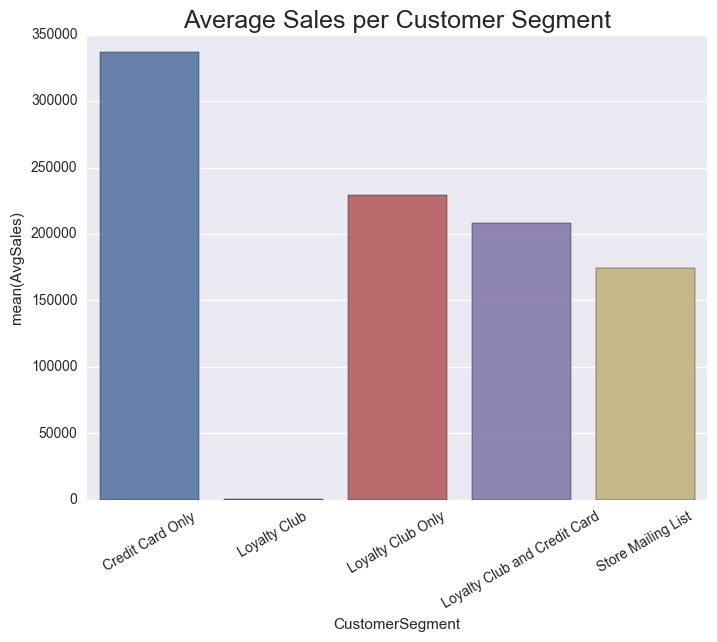

In [9]:
# read query into pandas dataframe 
df= pd.read_sql_query('''SELECT CustomSegment, SUM(AvgSales) FROM customers_cur
        GROUP BY CustomSegment''',conn)
#rename columns
df.columns=['CustomerSegment','AvgSales']

#plot the average sales per customer segment 
sns.plt.figure(figsize=(8,6)) #resize figure
sns.barplot(y='AvgSales',x='CustomerSegment',data=df,alpha=0.90) #create barplot
sns.plt.title('Average Sales per Customer Segment',fontsize=18) #add title
sns.plt.xticks(rotation=30) #rotate axis

In [10]:
#intert new customer into database
def add_cust(name,dbname="./Data/customers.db"):
    conn = sqlite3.connect(dbname) #connect to db
    c = conn.cursor() # create cursor object
    #insert new customer into table
    c.execute('''INSERT OR IGNORE INTO customers_cur VALUES(?,?,?,?,?,?,?,?,?,?,?,?)''',name)
    conn.commit() #commit insert
    conn.close() #close connection

if __name__=="__main__":
    name = tuple(("T Smith","Loyalty Club",5151,"920 Prescott","Denver","CO",80235,
        175.5,103,"Yes",3,2),)
    add_cust(name) #call add_cust function

In [11]:
#Check is new customer was added to database
def check_add_cust(name_cust,dbname="./Data/customers.db"):
    conn = sqlite3.connect(dbname) #connect to db
    c = conn.cursor() #create cursor object
    #check if customer was added to the table in the customers.db
    c.execute('''SELECT Name, City, State, Zip, CustomSegment FROM customers_cur WHERE NAME=(?)''', name_cust)
    print c.fetchone() #print query
    
name_cust = ("T Smith",) 
check_add_cust(name_cust)

(u'T Smith', u'Denver', u'CO', 80235.0, u'Loyalty Club')


In [ ]:
# query for the higher end customers (total sales)
def get_highend_customers_sales(amount,cust_type,dbname="./Data/customers.db"):
    conn = sqlite3.connect(dbname)
    c = conn.cursor()
    cust = (cust_type,)
    query = [x for x in c.execute('''SELECT CustomSegment, AvgSales FROM customers_cur 
                WHERE CustomSegment=(?)''',cust)]
    count = sum([1 for x in query if x[1]>=amount])
    print "Customer Segment: %s" % cust_type
    print "Total Avg. Sales greater than $%sk: %s customers" % (amount,count)
    
try:
    cust_type = raw_input("Customer Type:")
    if cust_type in ["Store Mailing List", "Credit Card Only",
        "Loyalty Club Only","Loyalty Club and Credit Card"]:
        get_highend_customers_sales(100,cust_type)
except:
    print "Not a valid customer segment"

### Random Sample of Basic Query 

In [16]:
def get_random_sample(db='./Data/customers.db'):
    conn = sqlite3.connect(db)
    c = conn.cursor()
    #Query for total sales per each customer segment
    c.execute('''SELECT * FROM customers_cur ORDER BY RANDOM() LIMIT 5''')
    for row in c.fetchall():
        print(row)

In [17]:
get_random_sample(db='./Data/customers.db')

('Gina Einspahr', 'Store Mailing List', 966.0, '3961 S Carson St', 'Aurora', 'CO', 80014.0, 234.31, 104.0, 'No', 1.0, 3.0)
('Janice Neff', 'Store Mailing List', 1749.0, '1292 S Olathe Way', 'Aurora', 'CO', 80017.0, 184.2, 100.0, 'No', 3.0, 6.0)
('Karen Crigler', 'Store Mailing List', 2103.0, '17221 E Walsh Way', 'Aurora', 'CO', 80017.0, 192.04, 105.0, 'No', 2.0, 6.0)
('Susan Bobka', 'Store Mailing List', 2314.0, '7435 S Jackson Gap Way', 'Aurora', 'CO', 80016.0, 218.93, 104.0, 'No', 1.0, 1.0)
('Alesha Borne', 'Loyalty Club Only', 1016.0, '15358 E Saratoga Pl', 'Aurora', 'CO', 80015.0, 339.99, 104.0, 'No', 4.0, 1.0)
